In [1]:
# reload modules before execution (for the changing code in Src)
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt

In [3]:
# import helper functions
import sys
import os

current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
scripts_path = os.path.join(project_root, 'Src')

if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from plotting_utils import plot_metric_clusters, align_country_codes, plot_choropleth_map
from clustering import align_labels, compute_kmeans_metrics

In [4]:
countries_data = pd.read_csv("../Data/Processed/worried_data_processed.csv", index_col = "Country Name")

In [5]:
X_PCA = np.load("../Data/Processed/X_PCA.npy")

# Clustering
The main objective of this project is to compare country groups obtained through unsupervised clustering based on Findex data to:
- World Bank classification by income (4 groups),
- Division into Frontier, Emerging, and Developed Markets (3 groups),
- The Economist Democracy Index (4 groups, 10 subgroups).

The World Bank divides countries into four groups, so the aim is to obtain four clusters. The Economist Democracy Index categorizes countries into four main groups based on scores ranging from 0 to 10. The first three groups each have two subgroups, and the last one has four subgroups. Therefore, the aim is not only to obtain four clusters but also to obtain 10 clusters. The division into Frontier, Emerging, and Developed Markets consists of three groups. Additionally, Emerging Markets are sometimes subdivided into various subgroups.

# K-means

## Parameter tuning

### Number of Clusters

In [12]:
# Each k-Means does one pass (initializes once), measures WGSS, silhouette score and the number of samples with a negative silhouette score depending on the number of clusters
N = 1
K_min = 3
K_max = 21
cluster_no = list(range(K_min, K_max))
param_grid = {
    'n_clusters': cluster_no,
}
wgss, silh_score, neg_silh_score, _ = compute_kmeans_metrics(X_PCA, param_grid, iter_no = N)

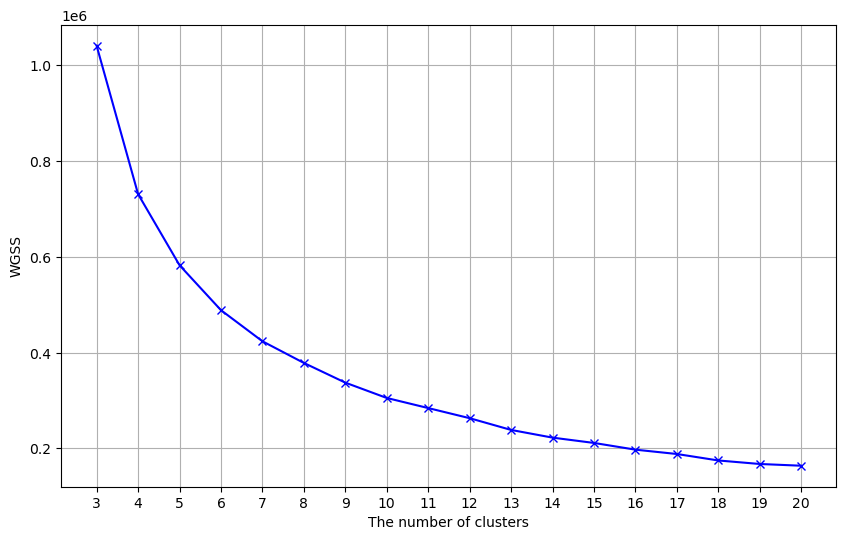

In [13]:
plt.figure(figsize = (10,6))
plt.plot(wgss.keys(), wgss.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("WGSS")
plt.grid(True)

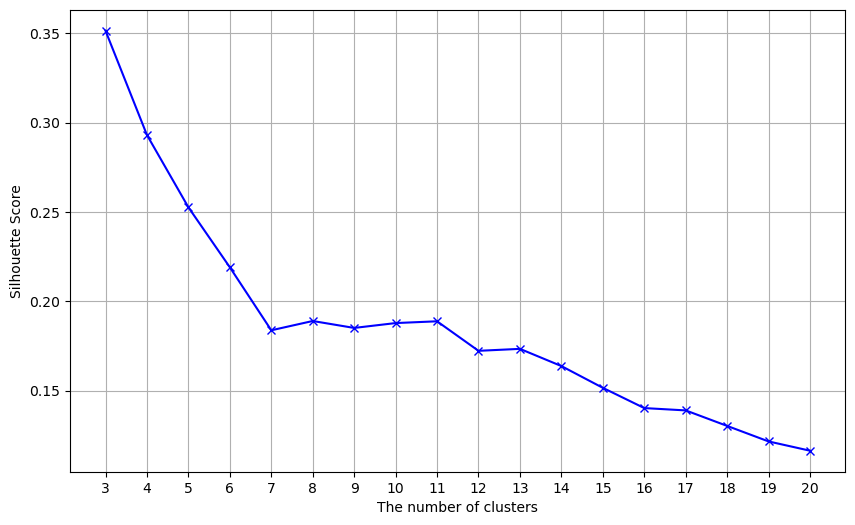

In [14]:
plt.figure(figsize = (10,6))
plt.plot(silh_score.keys(), silh_score.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("The number of clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

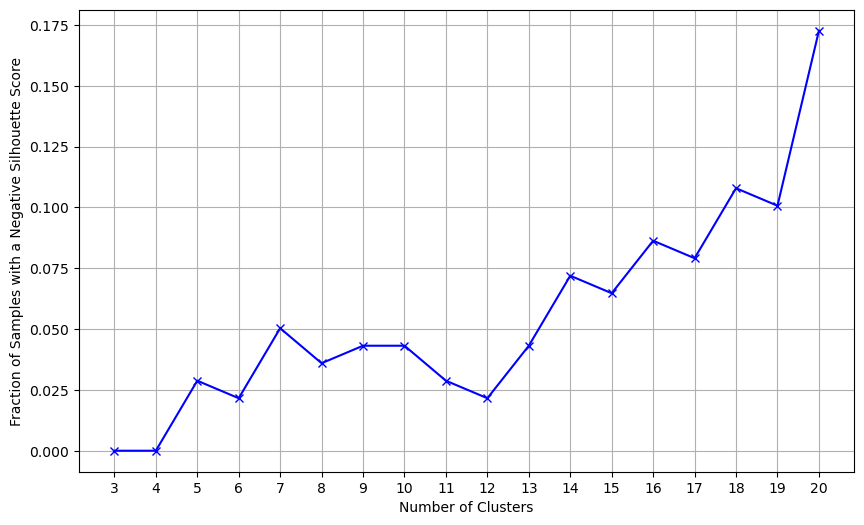

In [15]:
plt.figure(figsize = (10,6))
plt.plot(neg_silh_score.keys(), neg_silh_score.values(),  "bx-")
plt.xticks(np.arange(K_min, K_max))
plt.xlabel("Number of Clusters")
plt.ylabel("Fraction of Samples with a Negative Silhouette Score")
plt.grid(True)

#### Analysis of the Number of Clusters in K-means
Based on the WGSS, silhouette score, and the number of samples with a negative score, dividing the data into 3 or 4 clusters appears to be stable. The WGSS "elbow" occurs at 5 or 6 clusters, while dividing into 10 clusters results in relatively low WGSS, which may indicate unstable clustering.

The "elbow" of the silhouette score occurs around 7 clusters, further suggesting that 3 and 4 clusters provide stable clustering, whereas 10 clusters appear to be an unstable option.

Almost all samples have a positive silhouette score for 3 and 4 clusters, with less than 5% of samples having a negative silhouette score for 10 clusters.

### The Influence of K-means Parameters on the Robustness of Clusters
K-means clustering will be performed N = 50 times, and the label assignments for each country will be analyzed. The clustering is considered stable when each country is assigned the same label in almost every iteration.

There is no guarantee that the same cluster will retain the same label across different K-means iterations. To address this, label realignment is performed by solving the assignment problem, which involves maximizing the trace of the confusion matrix between the reference clustering and subsequent iterations. This ensures that the labels are consistently matched to the corresponding clusters across all runs.

#### n_init

In [18]:
N = 50
cluster_no = list(range(3, 11))
param_grid = {
    'n_clusters': cluster_no,
    'n_init': list(range(10, 111, 20)),
}
mean_wgss, mean_silh_score, mean_neg_silh_score, _ = compute_kmeans_metrics(X_PCA, param_grid, iter_no = N)

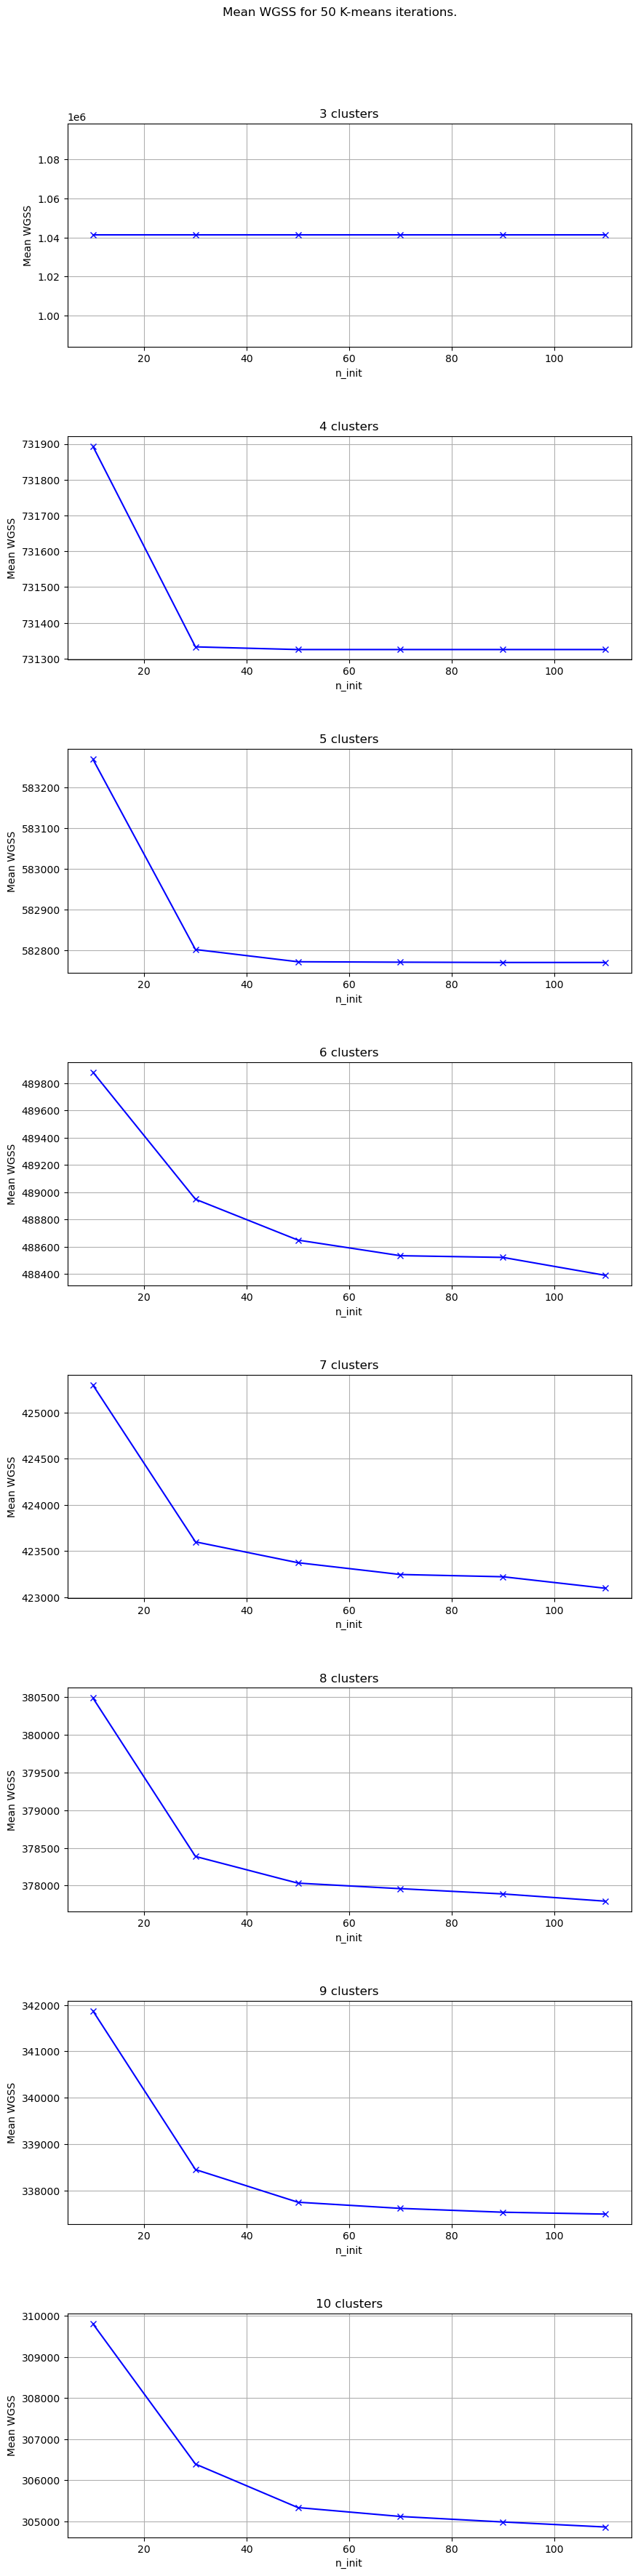

In [19]:
plot_title = " ".join(["Mean WGSS for", str(N), "K-means iterations."])
xlabel = "n_init"
ylabel = "Mean WGSS"
plot_metric_clusters(cluster_no, mean_wgss, N, plot_title, xlabel, ylabel)

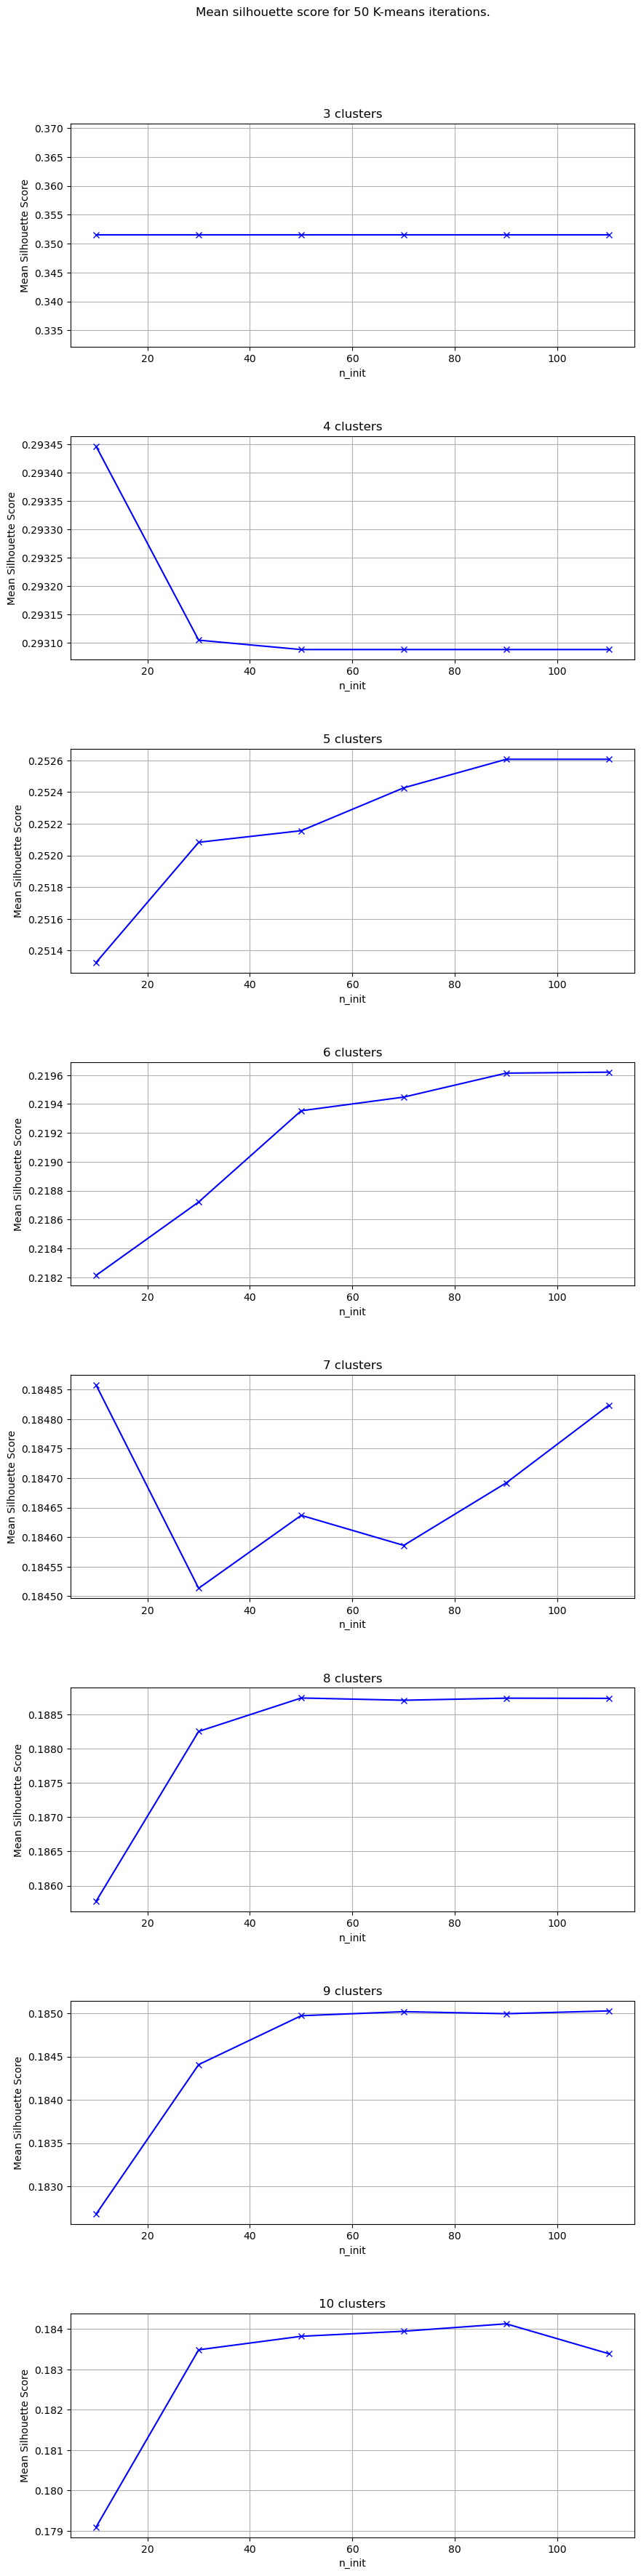

In [20]:
plot_title = " ".join(["Mean silhouette score for", str(N), "K-means iterations."])
xlabel = "n_init"
ylabel = "Mean Silhouette Score"
plot_metric_clusters(cluster_no, mean_silh_score, N, plot_title, xlabel, ylabel)

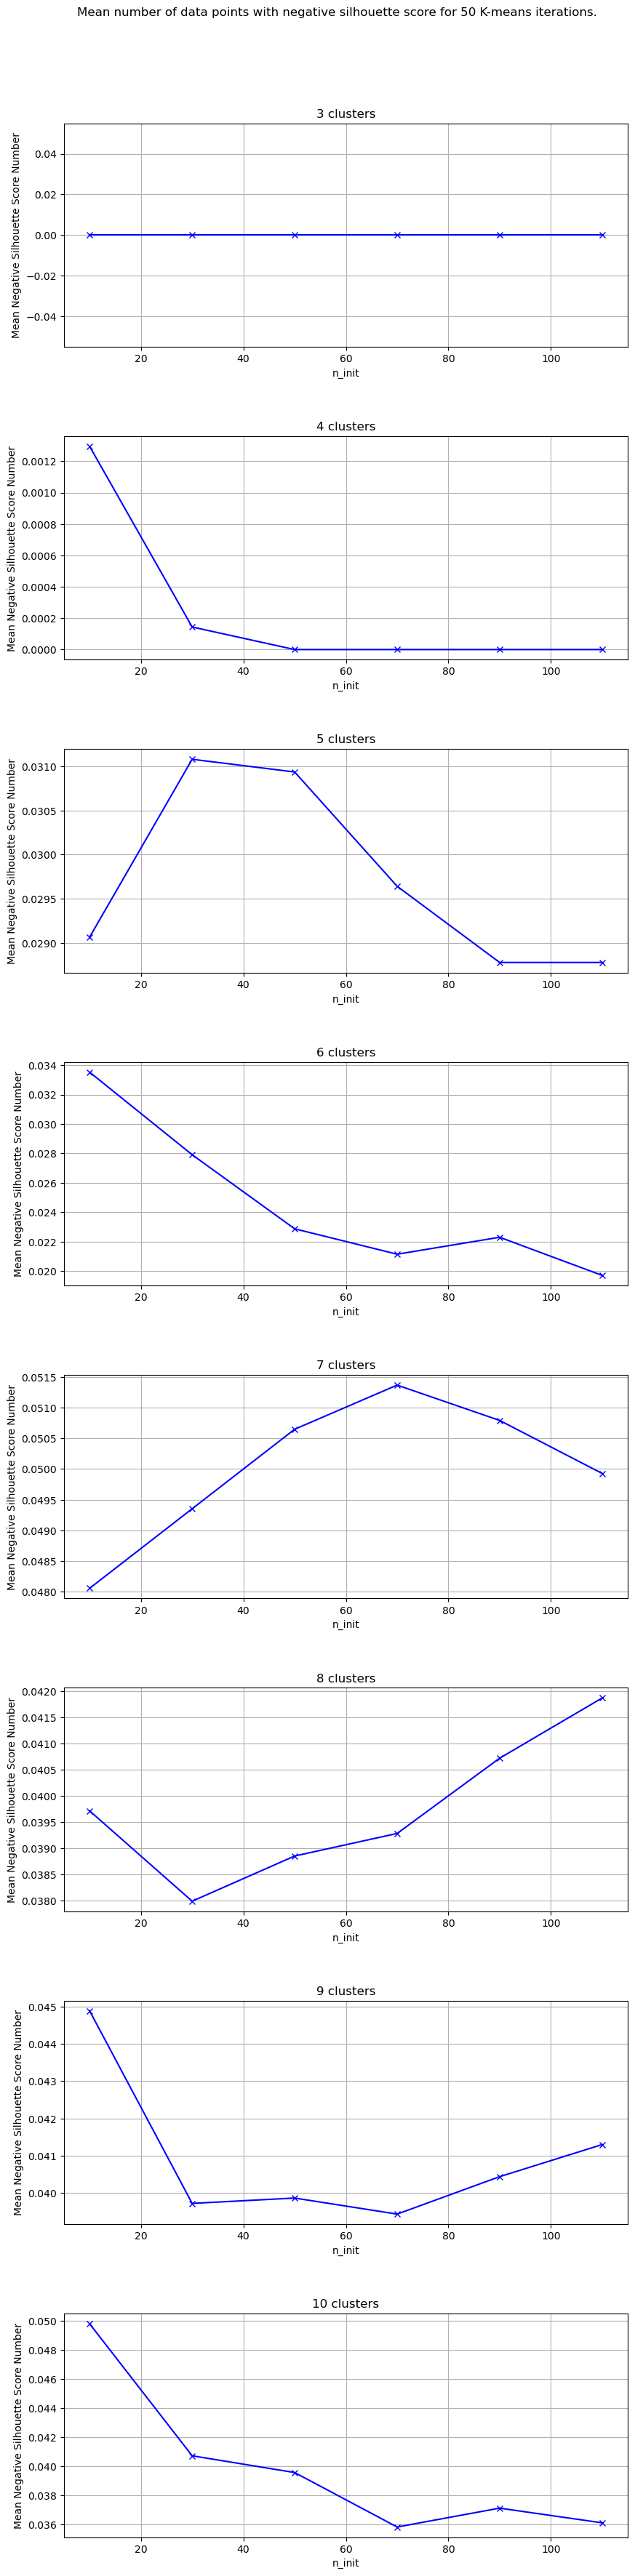

In [21]:
plot_title = " ".join(["Mean number of data points with negative silhouette score for", str(N), "K-means iterations."])
xlabel = "n_init"
ylabel = "Mean Negative Silhouette Score Number"
plot_metric_clusters(cluster_no, mean_neg_silh_score, N, plot_title, xlabel, ylabel)

#### Observations on the Influence of the n_init Parameter on the Robustness of Clustering
With an increasing number of random initializations, the solution quality—measured by WGSS and silhouette score—improves. For both WGSS and silhouette score, there appears to be an “elbow” at n_init = 30 for all cluster numbers greater than or equal to four.

The n_init parameter has no effect on clustering into three groups, which appears stable. As the number of clusters increases, there seem to be more local minima that K-means can get stuck in; however, with more random initializations, the algorithm is more likely to find optimal solutions.

TODO It is worth noting the magnitude of change

### Number of PCA principal components

In [22]:
N = 50
cluster_no = [3, 4, 10]
pc_no = [1, 3, 7, 22]
param_grid = {
    'n_clusters': cluster_no,
    'pca_components': pc_no
}
mean_wgss, mean_silh_score, mean_neg_silh_score, _ = compute_kmeans_metrics(X_PCA, param_grid, iter_no = N)

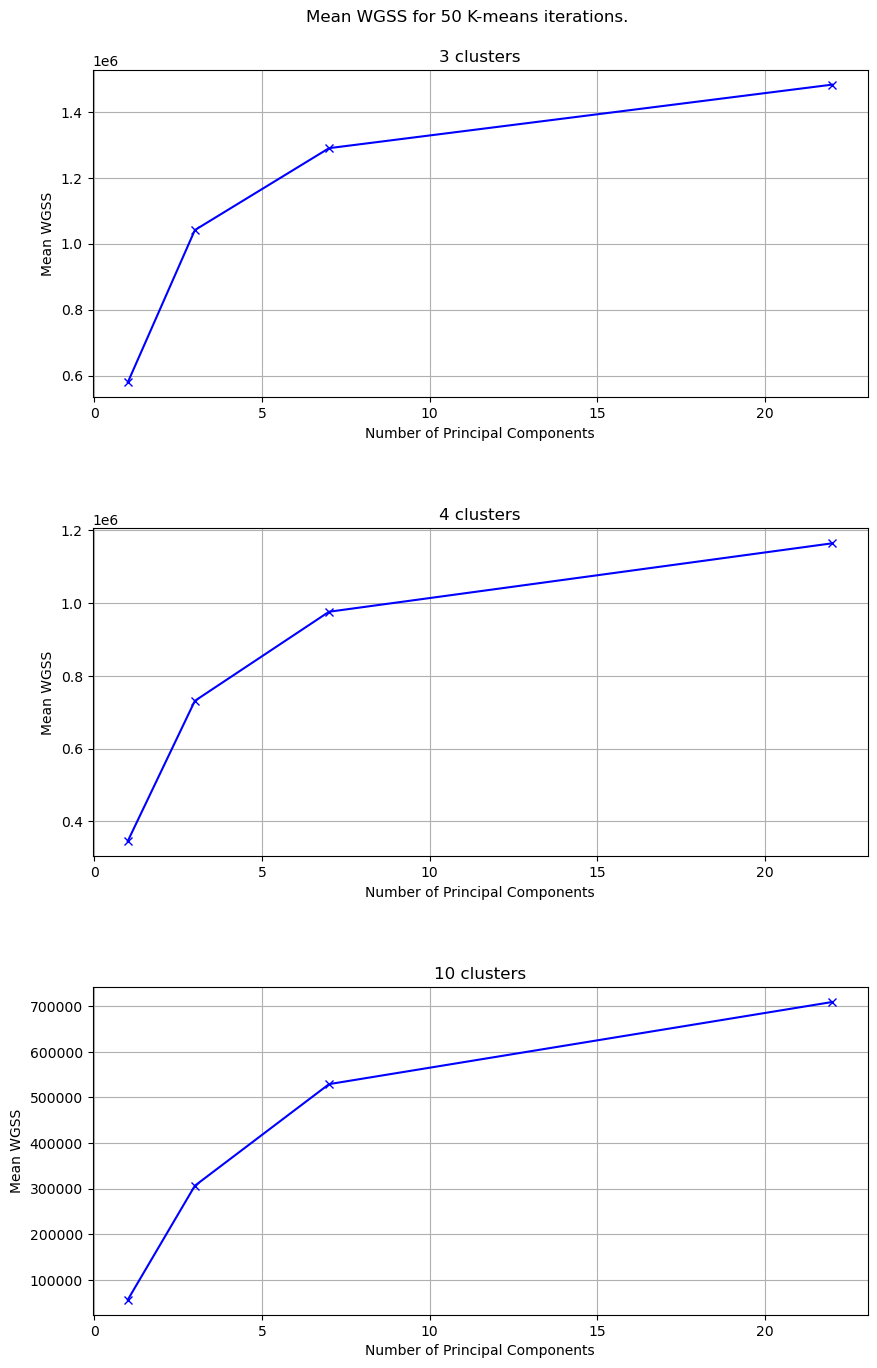

In [23]:
plot_title = " ".join(["Mean WGSS for", str(N), "K-means iterations."])
xlabel = "Number of Principal Components"
ylabel = "Mean WGSS"
plot_metric_clusters(cluster_no, mean_wgss, N, plot_title, xlabel, ylabel)

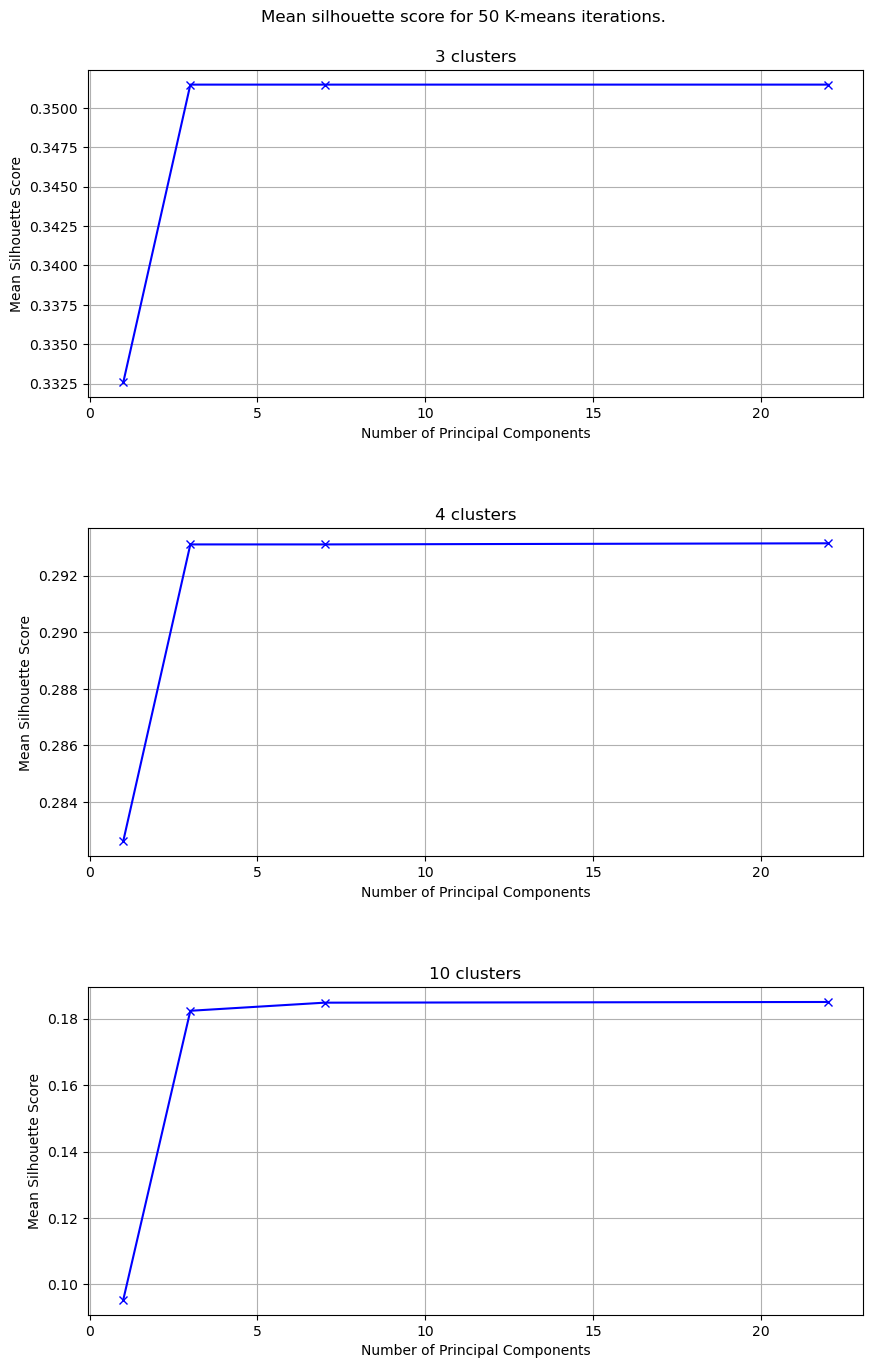

In [24]:
plot_title = " ".join(["Mean silhouette score for", str(N), "K-means iterations."])
xlabel = "Number of Principal Components"
ylabel = "Mean Silhouette Score"
plot_metric_clusters(cluster_no, mean_silh_score, N, plot_title, xlabel, ylabel)

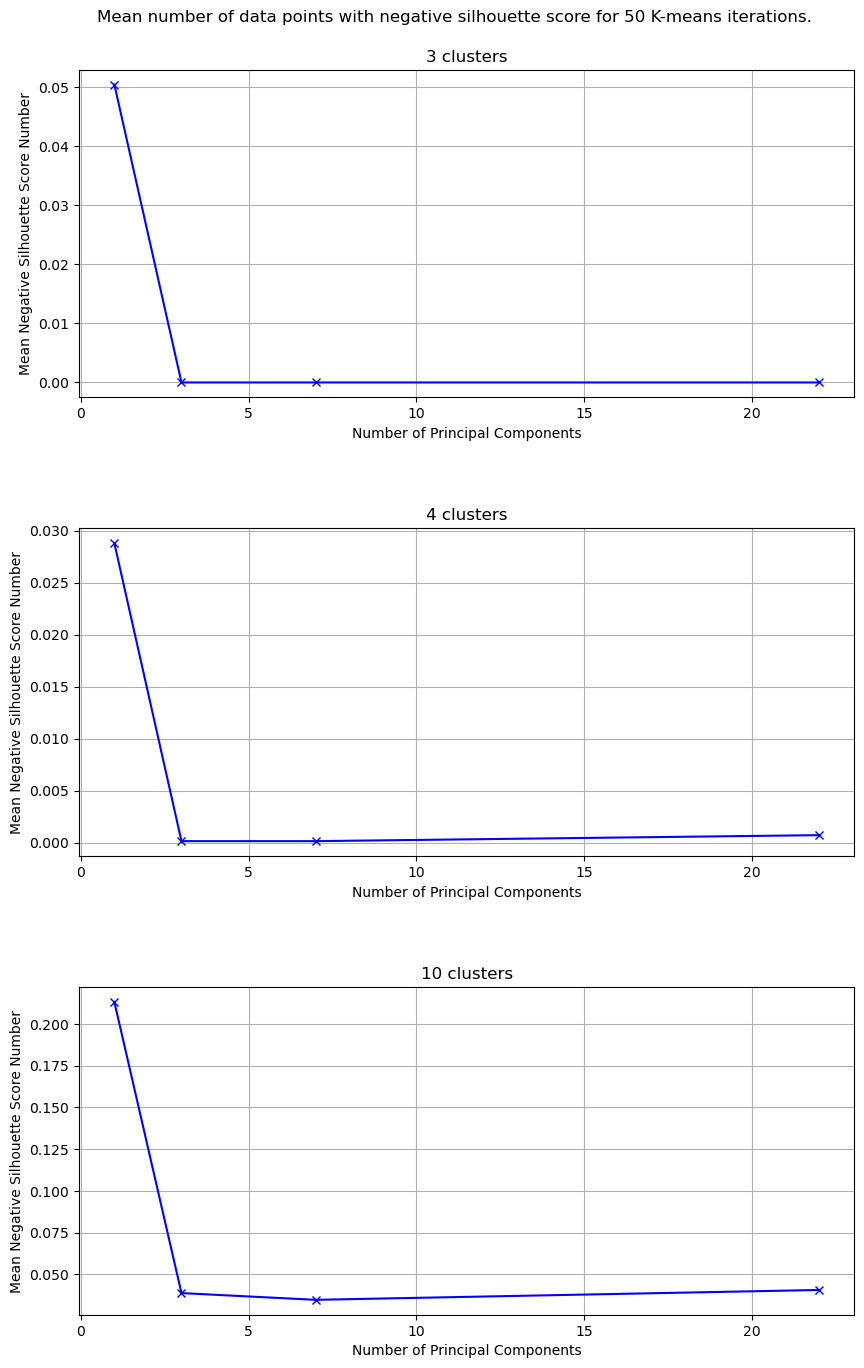

In [25]:
plot_title = " ".join(["Mean number of data points with negative silhouette score for", str(N), "K-means iterations."])
xlabel = "Number of Principal Components"
ylabel = "Mean Negative Silhouette Score Number"
plot_metric_clusters(cluster_no, mean_neg_silh_score, N, plot_title, xlabel, ylabel)

### Observations on the Influence of the Number of Principal Components on the Robustness of Clustering
It appears that as the number of principal components increases, the quality of clustering—measured by the within-group sum of squares (WGSS)—declines. This outcome is consistent with the K-means algorithm’s susceptibility to noise or redundant features, which add little discriminatory information.

In this dataset, after principal component analysis (PCA):
- The first principal component accounts for over 75% of the variance.
- Three principal components explain over 90% of the variance.
- Twenty two principal components together explain over 99% of the variance.

The main structure of the dataset is captured by the first three principal components. The subsequent components explain only a small fraction of the variance, diluting the clear separation in the data.

In contrast, the silhouette score improves when more of the total variance is included in the principal components. It reaches an “elbow” at three principal components (capturing over 90% of the variance) and does not show a significant improvement with additional components. Adding more principal components beyond this point increases complexity and introduces noise, thus raising WGSS without further boosting the silhouette score.

# Final Clustering

In [6]:
countries_labels = pd.DataFrame(index = countries_data.index)
countries_labels["Country Code"] = countries_data["Country Code"]

## K-means

In [28]:
# Default n_init = 30, default no of principal components = 3, based on parameter tuning
N = 50
cluster_no = range(3, 11)
#cluster_no = [10]
param_grid = {
    'n_clusters': cluster_no,
}
mean_wgss, mean_silh_score, mean_neg_silh_score, labels = compute_kmeans_metrics(X_PCA, param_grid, iter_no = N)

## Hierarchical clustering based on multiple K-means output
To mitigate the randomness inherent in k-means clustering (stemming from centroid initialization), a consensus matrix is first constructed by aggregating multiple k-means outputs, indicating how frequently each pair of countries appears together. This consensus matrix is then converted into a distance matrix (using 1 - consensus value, to obtain small distance for countries frequently clustered together), and hierarchical clustering is applied to determine the final clusters.

In [29]:
from itertools import combinations
def consensus_matrix(labels):
    iter_no, data_no = labels.shape
    consensus = np.zeros((data_no, data_no))
    # for each country pair
    for country, other in combinations(range(data_no), 2):
        # calculate fraction of times countries are clustered together
        cons_value = np.sum(K_labels[:,country] == K_labels[:, other])/iter_no
        consensus[country, other] = consensus[other, country] = cons_value
    np.fill_diagonal(consensus, 1)
    return consensus

In [30]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# consensus matrix and hierarchical clustering
final_labels = {}

for K in cluster_no:
    K_labels = labels[(K,)] # 2D array

    # prepare a distance matrix
    # First a consensus matrix is constructed
    # Consensus, that is frequency of clustering together is treated as a measure of similarity
    # Distance is defined 1 - consensus,
    # so the clusters frequently clustered together are close
    dist_matrix = 1 - consensus_matrix(K_labels)
    cond_dist_matrix = squareform(dist_matrix)

    # TODO explore methods
    Z = linkage(cond_dist_matrix, method='average')
    cluster_labels = fcluster(Z, t = K, criterion='maxclust')
    final_labels[K] = cluster_labels

In [31]:
for K in cluster_no:
    #K_label_array = labels[(K,)]
    column_name = "".join([str(K), "_clusters"])
    countries_labels[column_name] = final_labels[K]

In [32]:
countries_labels.reset_index(inplace = True)

In [33]:
countries_labels.to_csv("../Results/countries_labels.csv")
countries_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         139 non-null    int64 
 1   Country Name  139 non-null    object
 2   Country Code  139 non-null    object
 3   10_clusters   139 non-null    int32 
 4   3_clusters    139 non-null    int32 
 5   4_clusters    139 non-null    int32 
 6   5_clusters    139 non-null    int32 
 7   6_clusters    139 non-null    int32 
 8   7_clusters    139 non-null    int32 
 9   8_clusters    139 non-null    int32 
 10  9_clusters    139 non-null    int32 
dtypes: int32(8), int64(1), object(2)
memory usage: 7.7+ KB


# Final Clustering visualisation

In [34]:
import geopandas as gpd

In [35]:
world_file = "~/Financial_Attitudes_Clustering/Data/Raw/geodatasets/ne_10m_admin_0_countries.shp"
world = gpd.GeoDataFrame.from_file(world_file)
changed_codes = align_country_codes(countries_labels, world, "Country Code", "Country Name", "SOV_A3", "NAME", updated_code_col = "World Country Code", fuzzy_threshold = 60)

In [36]:
countries_labels

index        Country Name Country Code  10_clusters  3_clusters  \
0        0         Afghanistan          AFG            4           1   
1        1             Albania          ALB            2           1   
2        2             Algeria          DZA            7           3   
3        3           Argentina          ARG            1           3   
4        4             Armenia          ARM           10           3   
..     ...                 ...          ...          ...         ...   
134    134             Vietnam          VNM            7           3   
135    135  West Bank and Gaza          PSE            1           3   
136    136         Yemen, Rep.          YEM            1           3   
137    137              Zambia          ZMB            5           1   
138    138            Zimbabwe          ZWE            5           1   

     4_clusters  5_clusters  6_clusters  7_clusters  8_clusters  9_clusters  \
0             2           2           6           3           2           8   
1             1           2           6           5           1           7   
2             4           5           4           6           8           3   
3             1           3           5           7           6           6   
4             4           3           4           6           7           5   
..          ...         ...         ...         ...         ...         ...   
134           4           5           4           6           8           3   
135           1           3           5           7           6           6   
136           1           3           5           7           6           6   
137           2           1           3           4           3           9   
138           2           1           3           4           3           9   

    World Country Code  
0                  AFG  
1                  ALB  
2                  DZA  
3                  ARG  
4                  ARM  
..                 ...  
134                VNM  
135                PSE  
136                YEM  
137                ZMB  
138                ZWE  

[139 rows x 12 columns]

In [37]:
# TODO create and save a frequency matrix for data point on the decision boundary analysis

In [38]:
# TODO add consensus clustering to mode clustering for differing KMeans runs (with choice of DBScan and hierarchical clustering maybe)

In [39]:
# TODO take care of Hong Kong, same code as China
# TODO report the countries not found at all
changed_codes

[('Australia', 'AUS', 'Australia', 'AU1'),
 ('China', 'CHN', 'China', 'CH1'),
 ('Denmark', 'DNK', 'Denmark', 'DN1'),
 ('Finland', 'FIN', 'Finland', 'FI1'),
 ('France', 'FRA', 'France', 'FR1'),
 ('Hong Kong SAR, China', 'HKG', 'Hong Kong', 'CH1'),
 ('Israel', 'ISR', 'Israel', 'IS1'),
 ('Kazakhstan', 'KAZ', 'Kazakhstan', 'KA1'),
 ('Kosovo', 'XKX', 'Kosovo', 'KOS'),
 ('Netherlands', 'NLD', 'Netherlands', 'NL1'),
 ('New Zealand', 'NZL', 'New Zealand', 'NZ1'),
 ('South Sudan', 'SSD', 'S. Sudan', 'SDS'),
 ('United Kingdom', 'GBR', 'United Kingdom', 'GB1'),
 ('United States', 'USA', 'United States of America', 'US1')]

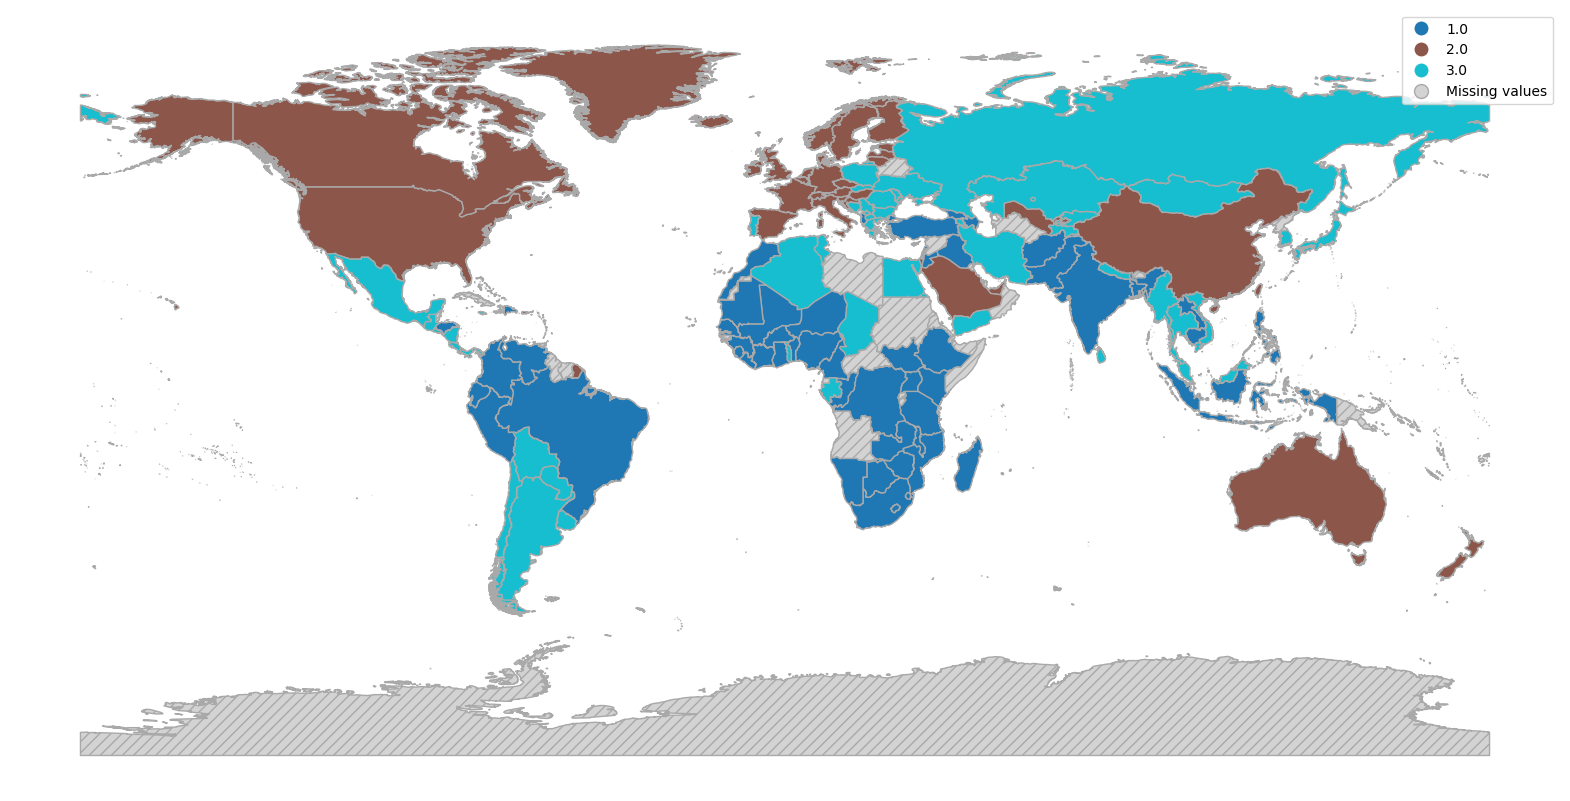

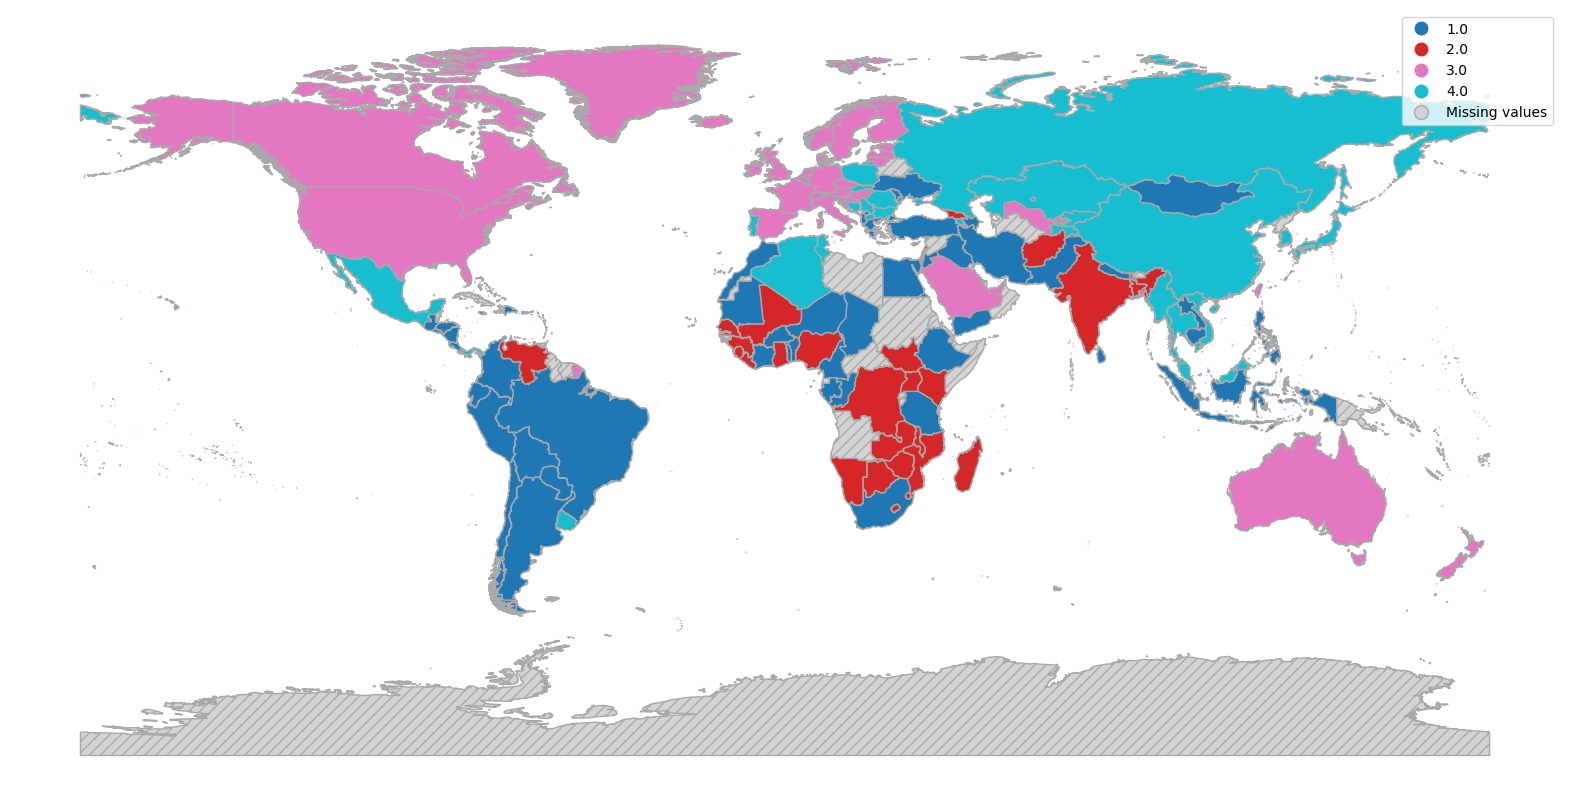

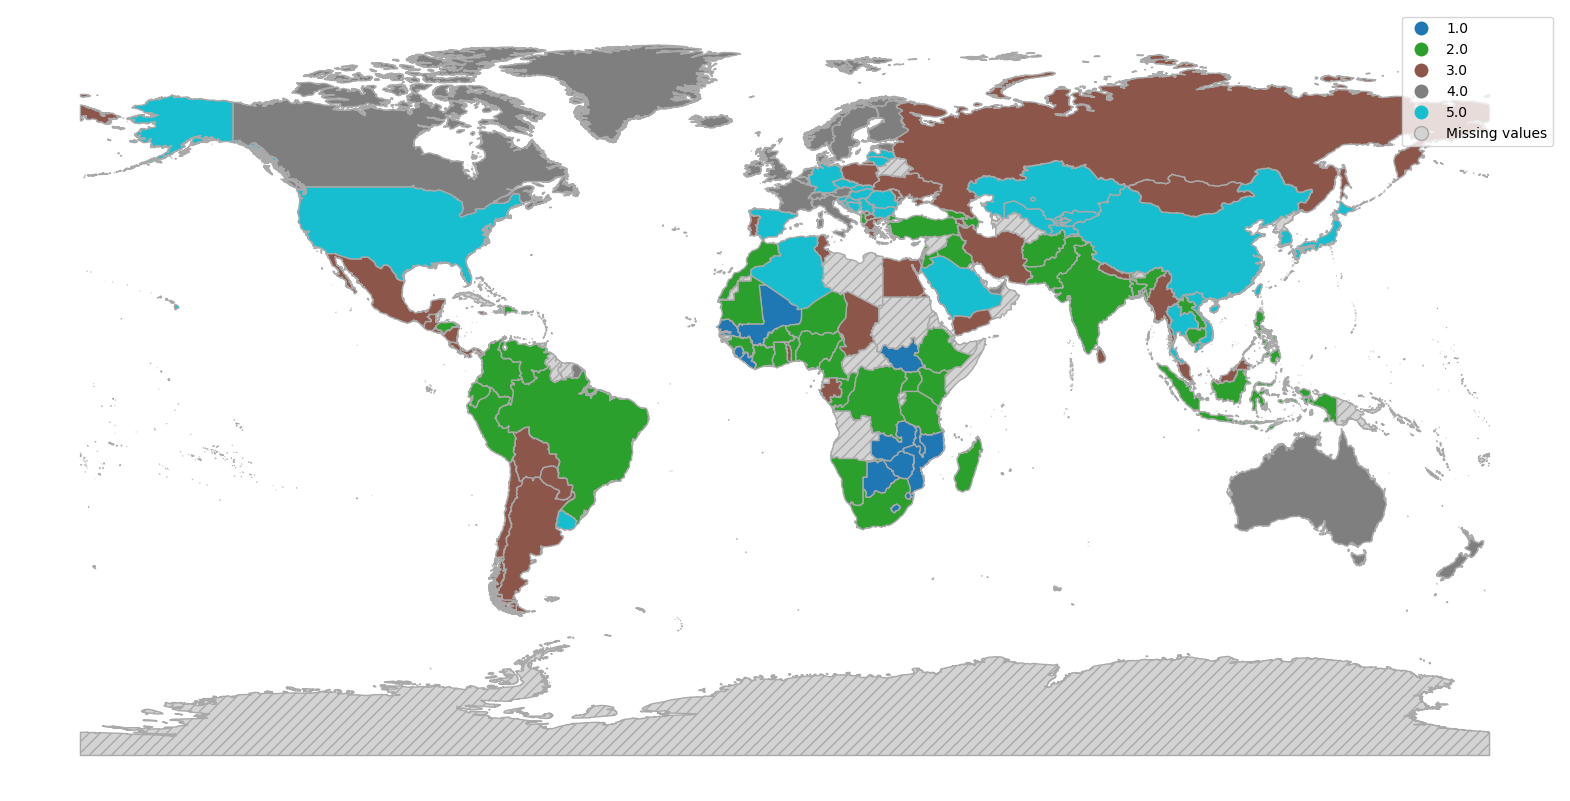

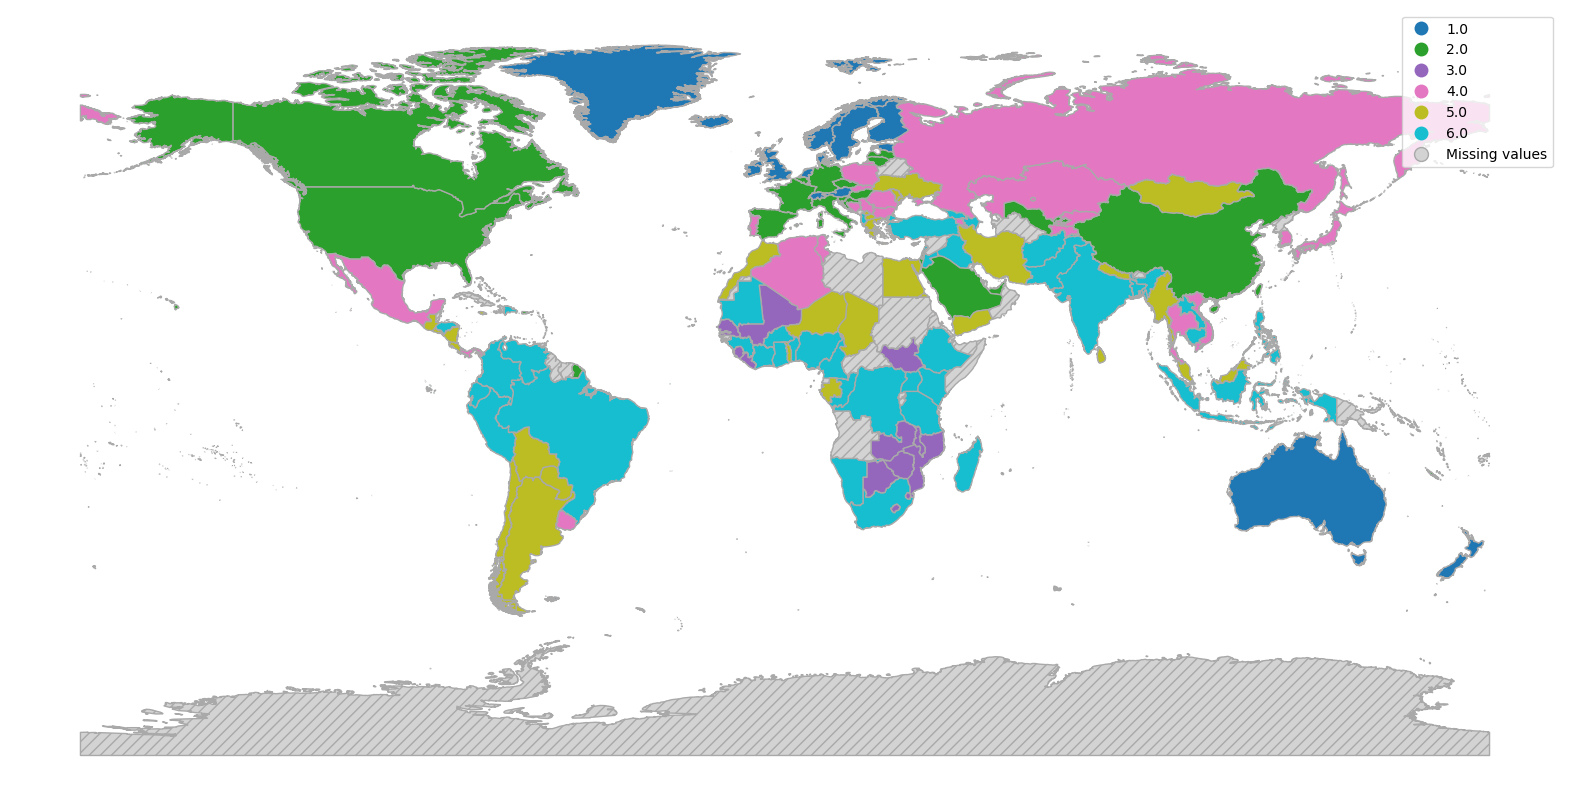

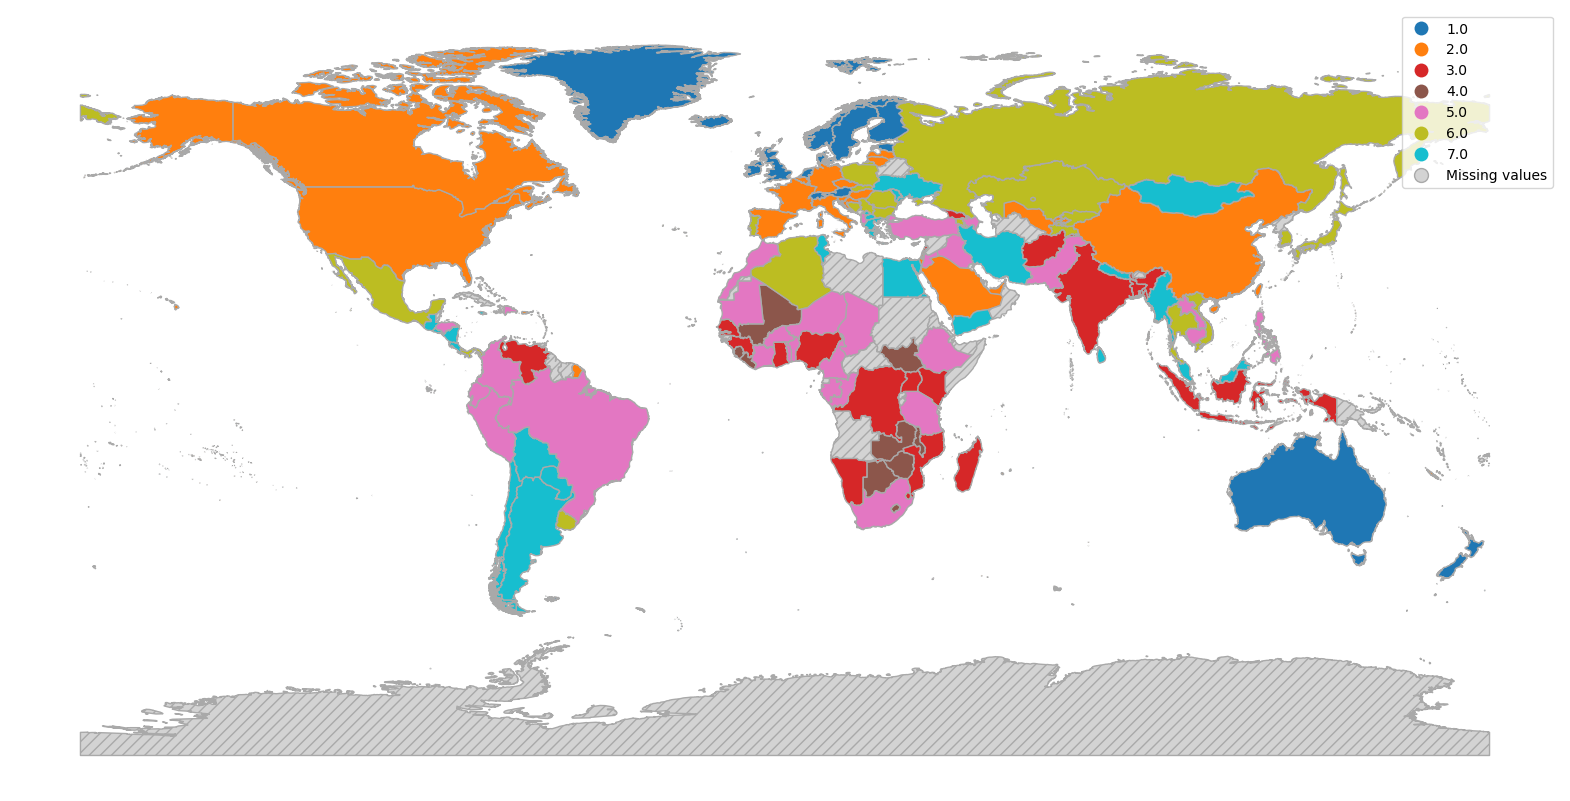

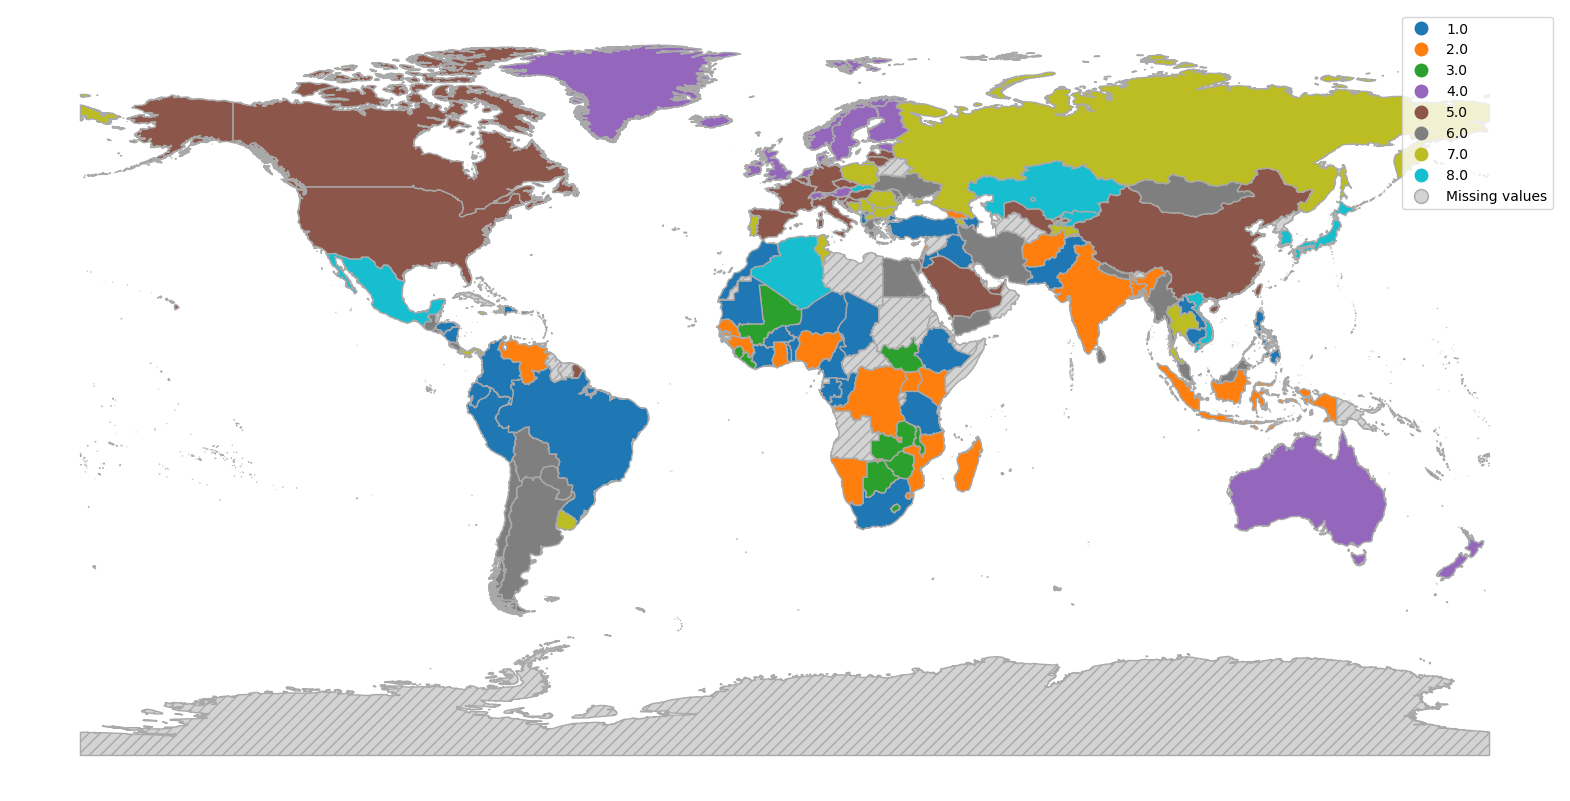

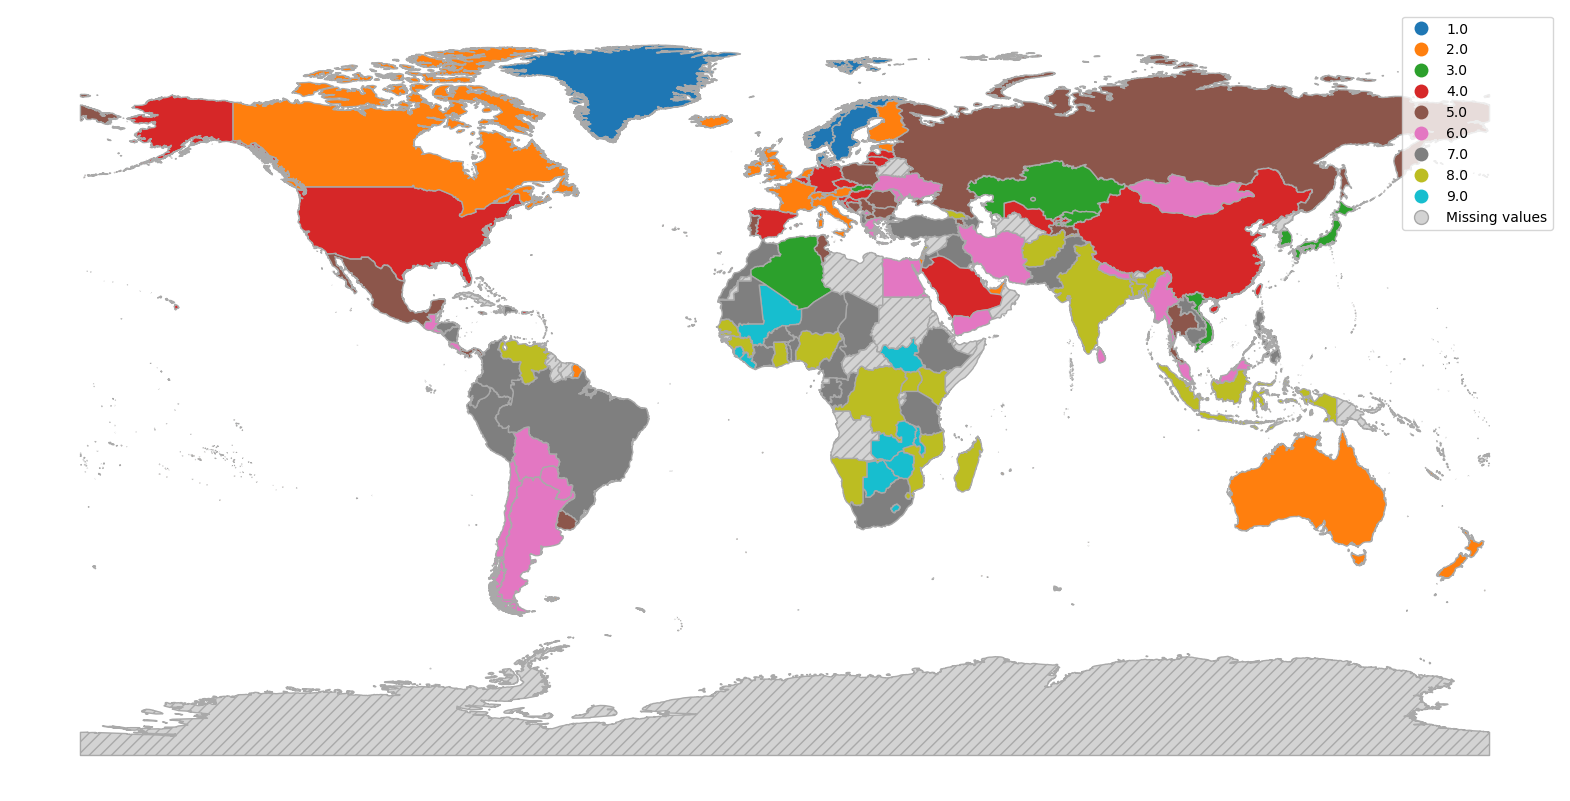

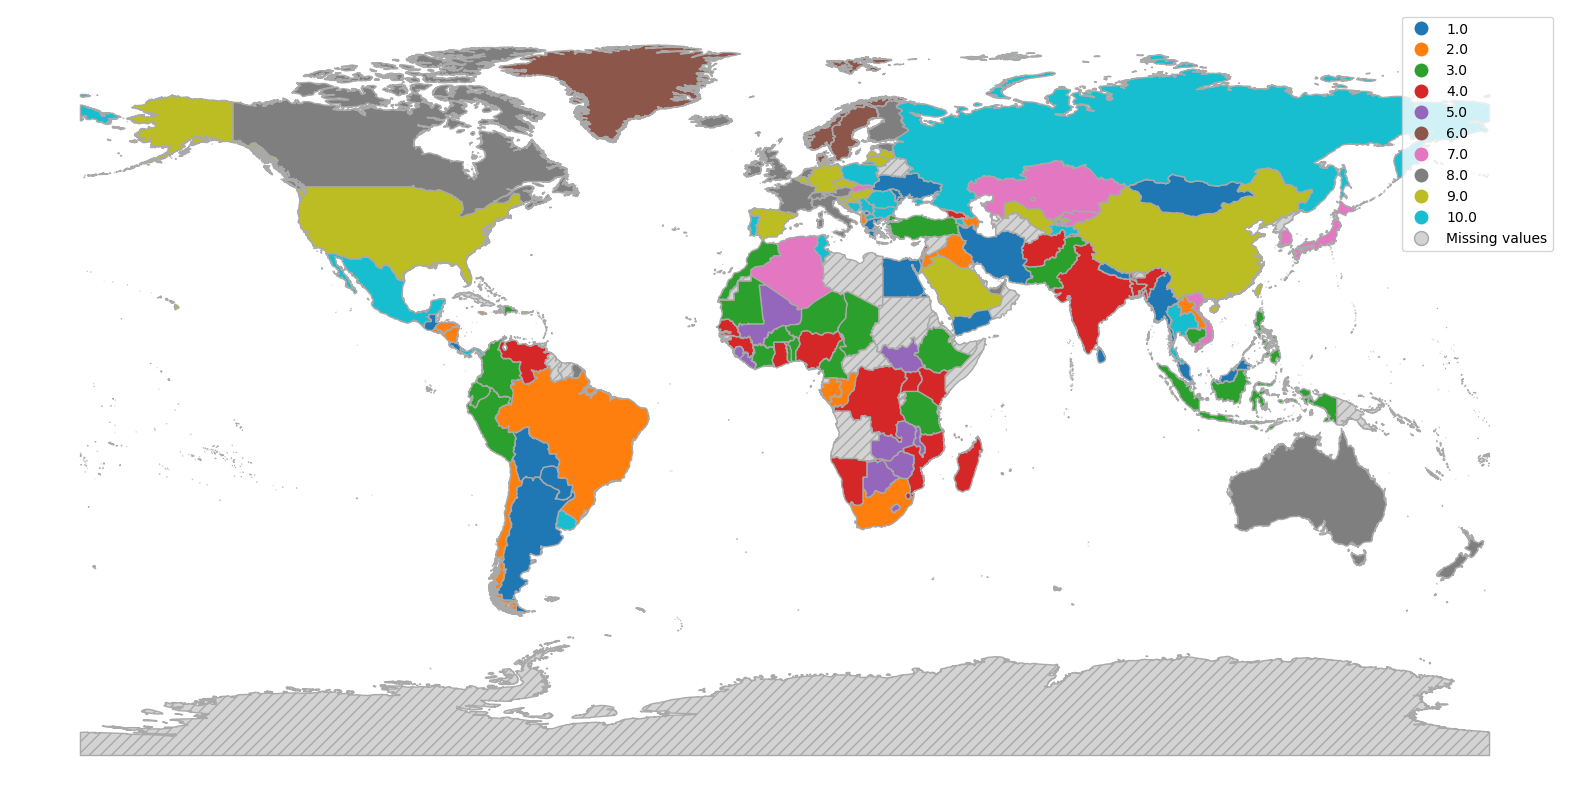

In [40]:
for K in cluster_no:
    output_file = "".join(["../Results/map_", str(K), "_clusters.png"])
    cluster_column_name = "".join([str(K), "_clusters"])
    plot_choropleth_map(countries_labels, world_file, merge_column = "World Country Code", cluster_column = cluster_column_name, output_filename = output_file)

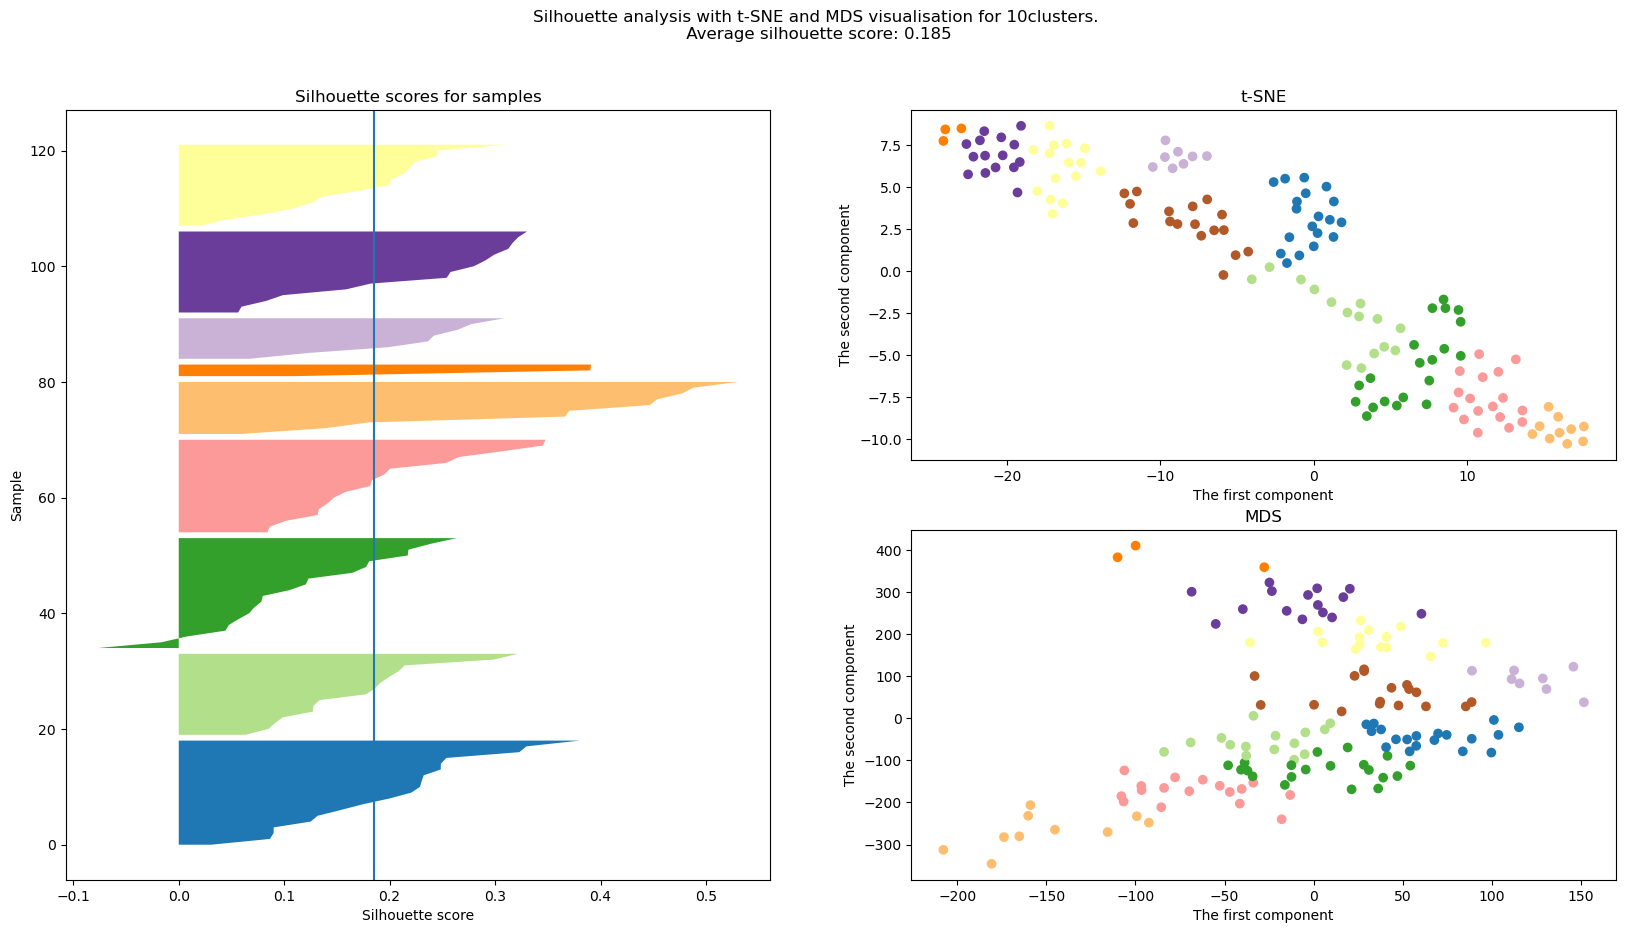

In [42]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE, MDS

K = 10
label_col_name = "".join([str(K), "_clusters"])

avg_silh_score = silhouette_score(X_PCA, countries_labels[label_col_name])
silh_score_ind = silhouette_samples(X_PCA, countries_labels[label_col_name])

tsne_embedding = TSNE(n_components = 2, perplexity = 20).fit_transform(X_PCA[:, 0:3])
mds_embedding = MDS(n_components = 2).fit_transform(X_PCA[:, 0:3])

#colormap = plt.cm.tab20
colormap = plt.cm.Paired
colors = colormap(countries_labels[label_col_name].astype(float) / K)

fig, axs = plt.subplot_mosaic([['A', 'B'],['A', 'C']], figsize = (20,10))

y_start = 0
for cluster in range(K):
    cluster_silh_score_ind = silh_score_ind[countries_labels[label_col_name] == cluster]
    cluster_silh_score_ind.sort()

    y_end = y_start + cluster_silh_score_ind.shape[0]
    color = colormap(cluster/K)
    axs['A'].fill_betweenx(np.arange(y_start, y_end), 0, cluster_silh_score_ind, facecolor = color)

    y_start = y_end
axs['A'].axvline(avg_silh_score)
axs['A'].set_title("Silhouette scores for samples")
axs['A'].set_xlabel("Silhouette score")
axs['A'].set_ylabel("Sample")

axs['B'].scatter(tsne_embedding[:,0], tsne_embedding[:,1], c = colors)
axs['B'].set_title("t-SNE")
axs['B'].set_xlabel("The first component")
axs['B'].set_ylabel("The second component")

axs['C'].scatter(mds_embedding[:,0], mds_embedding[:,1], c = colors)
axs['C'].set_title("MDS")
axs['C'].set_xlabel("The first component")
axs['C'].set_ylabel("The second component")

title = "".join(["Silhouette analysis with t-SNE and MDS visualisation for ", str(K), "clusters.",
                "\n Average silhouette score: ", str(np.round(avg_silh_score, 3))])
plt.suptitle(title)

plt.show()